In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from joblib import dump
from openai import OpenAI
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Initial OpenAI API Key
openai_api_key= "Add Your OpenAI API KEY Here."

In [3]:
def generate_embeddings(text):
    """Generate vector embeddings for input text using an OpenAI embedding model."""   
    client = OpenAI(api_key=openai_api_key)
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data

# Load the dataset
df = pd.read_csv("training_data.csv")

# Generate embeddings
text_embeddings = generate_embeddings(df['Table_title'])
text_embedding_list = [text_embeddings[i].embedding for i in range(len(text_embeddings))]

column_names = ["embedding_" + str(i) for i in range(len(text_embedding_list[0]))]
df_train = pd.DataFrame(text_embedding_list, columns=column_names)

df_train['is_LCI'] = df['is LCI inventory table?']=="Yes"

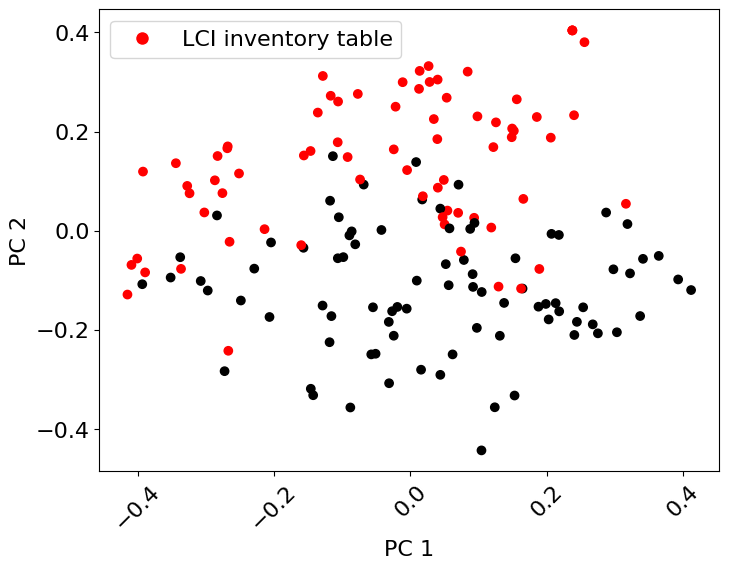

In [4]:
# Split variables by predictors and target
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

# Apply PCA to predictors (embeddings)
pca = PCA(n_components=2).fit(X)
c_arr = np.array(["k"] * len(y))
c_arr[y == True] = "r"

# Creating the PCA scatter plot
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=c_arr)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='LCI inventory table',
                          markerfacecolor='r', markersize=10)]
plt.legend(handles=legend_elements)
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# Randomized hyperparameter tuning for a rf classifier
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 13, 'n_estimators': 331}


In [7]:
# Train rf classifier
rf = RandomForestClassifier(
    n_estimators=418,  
    max_depth=8,        # Increased depth to capture more complex patterns, adjust as needed
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    min_samples_leaf=4,    # Minimum number of samples required to be at a leaf node
    random_state=42         # Ensures reproducibility
)

rf.fit(X_train, y_train)
rf.score(X,y) # model accuracy for training data

dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [8]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9375


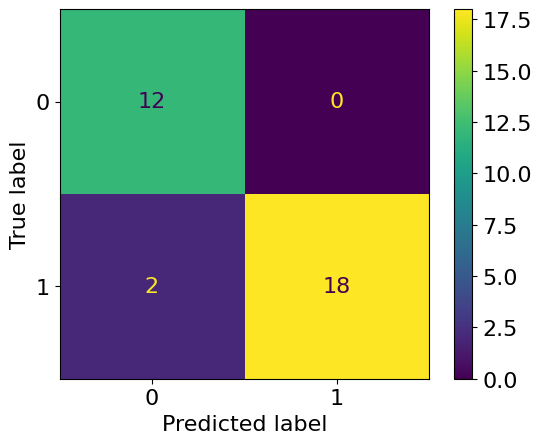

In [11]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();